In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using NearestNeighbors
using DataFrames

using LevelKRacing


Use "Frames{M}(...) where M" instead.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] warn_shell_special(::String) at ./shell.jl:8
 [3] #shell_parse#236(::String, ::Function, ::String, ::Bool) at ./shell.jl:103
 [4] (::Base.#kw##shell_parse)(::Array{Any,1}, ::Base

.#shell_parse, ::String, ::Bool) at ./<missing>:0 (repeats 2 times)
 [5] @cmd(::ANY) at ./process.jl:796
 [6] include_from_node1(::String) at ./loading.jl:569
 [7] eval(::Module, ::Any) at ./boot.jl:235
 [8] _require(::Symbol) at ./loading.jl:483
 [9] require(::Symbol) at ./loading.jl:398
 [10] include_from_node1(::String) at ./loading.jl:569
 [11] eval(::Module, ::Any) at ./boot.jl:235
 [12] _require(::Symbol) at ./loading.jl:483
 [13] require(::Symbol) at ./loading.jl:398
 [14] include_string(::String, ::String) at ./loading.jl:515
 [15] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/kyle/.julia/v0.6/IJulia/src/execute_request.jl:156
 [16] eventloop(::ZMQ.Socket) at /Users/kyle/.julia/v0.6/IJulia/src/eventloop.jl:8
 [17] (::IJulia.##9#12)() at ./task.jl:335
while loading /Users/kyle/.julia/v0.6/Reel/src/Reel.jl, in expression starting on line 165

Use "abstract type Camera end" instead.

Use "CarFollowCamera{I}(...) where I" instead.

Use "abstract type SceneOverlay end" inste

In [36]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps

# car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

############### INITIALIZE TRACK ################
lane_width = 30.0
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
Pts = Array(readtable("trackPts.csv"))'

degree = 3 # degree of spline
num_points = 10001
num_samples = 420

track = Raceway(Pts,degree,num_points,num_samples,lane_width)
track;

roadind1 = RoadIndex(CurveIndex(12,0),LaneTag(1,1))
vehstate1 = VehicleState(Frenet(roadind1, track.roadway), track.roadway, 50.0)
vehdef1 = VehicleDef(AgentClass.CAR, car_length, car_width)
push!(scene, Vehicle(vehstate1, vehdef1, 1))

for i in 1:10
    track.models[i] = HRHC(1,track.roadway,h=8+2*i,v_max=120.0,μ=15.0,a_step=12.0,a_range=[-1,0,1],k=0)
end
# track.models[1] = HRHC(1,track.roadway,h=12,v_max=120.0,μ=30.0,a_step=12.0,a_range=[-1,0,1],k=0)
# track.models[2] = HRHC(1,track.roadway,h=12,v_max=120.0,μ=15.0,a_step=12.0,a_range=[-1,0,1],k=0)
# track.models[3] = HRHC(1,track.roadway,h=18,v_max=120.0,μ=15.0,a_step=12.0,a_range=[-1,0,1],k=0)
# track.models[4] = HRHC(1,track.roadway,h=18,v_max=120.0,μ=15.0,a_step=12.0,a_range=[-1,0,1],k=0)

track.obstacleMap = generateObstacleMap(scene, track.models)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] Array(::Type{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}}, ::Int64) at ./deprecated.jl:51
 [3] Type at /Users/kyle/.julia/v0.6/Records/src/frames.jl:11 [inlined]
 [4] Type at /Users/kyle/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/scenes.jl:2 [inlined] (repeats 2 times)
 [5] include_string(::String, ::String) at ./loading.jl:515
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/kyle/.julia/v0.6/IJulia/src/execute_request.jl:156
 [7] eventloop(::ZMQ.Socket) at /Users/kyle/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##9#12)() at ./task.jl:335
while loading In[36], in expression starting on line 2
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] atan2(::Array{Float64,1}, ::Array{Float64,1}) at ./deprecated.jl:51
 [3] LevelKRacing.Raceway(::Array{Real,2}, ::Int64, ::Int64, ::Int64, ::Float64) at /Users/kyle/.julia/v0.6/Le

Dict{Any,Any} with 1 entry:
  0 => Dict{Any,Any}(Pair{Any,Any}(7, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … …

## Plot trajectory across track

In [37]:
x₀ = vehstate1.posG.x
y₀ = vehstate1.posG.y 
θ₀ = vehstate1.posG.θ

trajectories = Dict()

NUM_STEPS = 400
for (k, model) in track.models
    scene[1] = Vehicle(vehstate1, vehdef1, 1)
    traj = [x₀;y₀;θ₀]
    for i in 1:NUM_STEPS
        veh = scene[1]
        model = track.models[k]
        observe!(model, scene, track.roadway, 1, track.tree, track.obstacleMap, 0)
        scene[1] = Vehicle(model.action, veh.def, 1)
        x = scene[1].state.posG.x
        y = scene[1].state.posG.y 
        θ = scene[1].state.posG.θ
        traj = hcat(traj,[x;y;θ])
    end
    trajectories[k] = traj
end


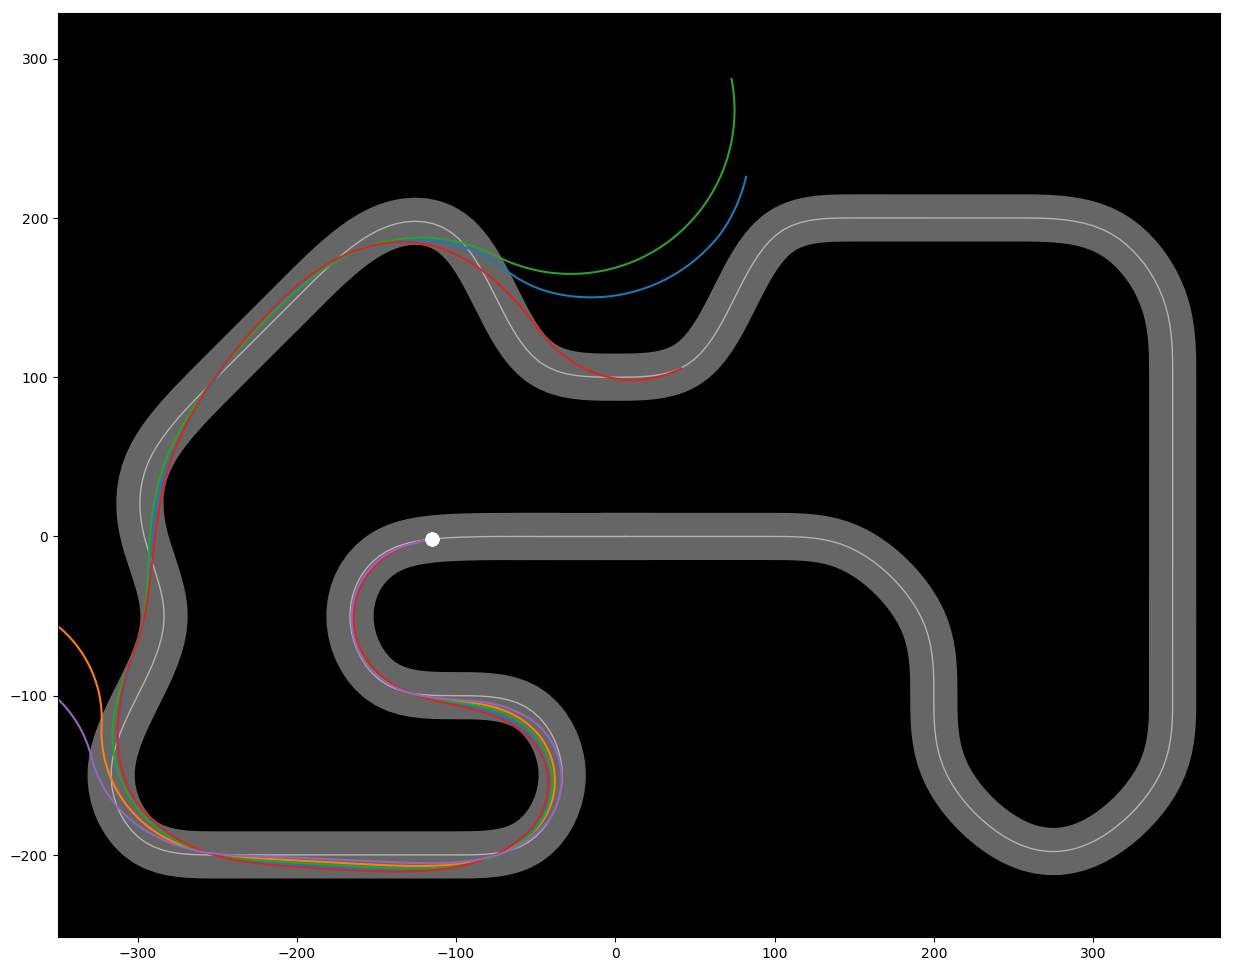

(-350, 380)

In [39]:
fig = PyPlot.figure(figsize=[15,12])
PyPlot.subplot("111", axisbg="black")
PyPlot.plot(track.x, track.y, c=[0.4,0.4,0.4], linewidth=34)
PyPlot.plot((track.x[1],track.x[end]), (track.y[1],track.y[end]), c=[0.4,0.4,0.4], linewidth=34)
PyPlot.plot(track.x, track.y, c=[0.7,0.7,0.7], linewidth=1)
PyPlot.plot((track.x[1],track.x[end]), (track.y[1],track.y[end]), c=[0.7,0.7,0.7], linewidth=1)
PyPlot.axis("equal")

# color_list = [[1,0,0],[0,1,0],[0,0,1],[1,1,0]]

for (k, traj) in trajectories
    if k < 6
        PyPlot.plot(traj[1,:],traj[2,:]) #,c=color_list[k])
    #     PyPlot.scatter(traj[1,:],traj[2,:],c=color_list[k],c=[1,1,1], edgecolor=color_list[k], s=20, zorder=4)
        PyPlot.scatter(traj[1,1], traj[2,1], c=[1,1,1], s=80, zorder=4)
    end
end
PyPlot.xlim([-350,380])

In [19]:
trajectories[2]

3×401 Array{Float64,2}:
 -115.048     0.0104602    0.0313807   …   1.04274     1.04274     1.04274  
   -1.62877  -7.17862e-6  -6.46075e-5     -0.0716736  -0.0716736  -0.0716736
   -2.91775  -0.00137255  -0.00411766     -0.137255   -0.137255   -0.137255 

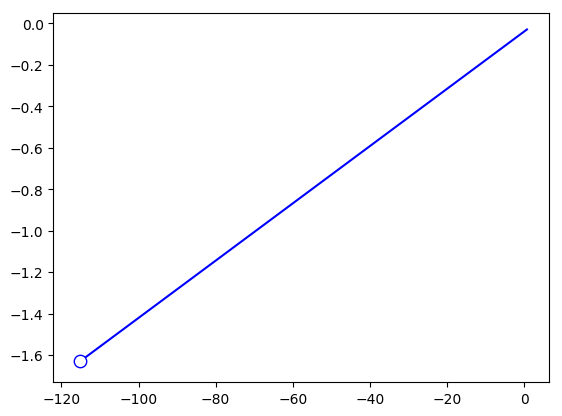

PyObject <matplotlib.collections.PathCollection object at 0x1074087d0>

In [24]:
k = 3
traj = trajectories[k]
PyPlot.plot(traj[1,:],traj[2,:],c=color_list[k])
PyPlot.scatter(traj[1,1], traj[2,1], c=[1,1,1], edgecolor=color_list[k], s=80, zorder=4)

In [ ]:
observe!(model, scene, track.roadway, veh.id, track.tree, track.obstacleMap, 0)
# scene[1] = Vehicle(model.action, veh.def, veh.id)

In [ ]:
scene[1] = Vehicle(model.action, veh.def, veh.id)

In [ ]:
track.roadway.segments[1].lanes[1].width

In [ ]:
function drawsim(t, dt=NaN)
    for (i, veh) in enumerate(scene)
        model = track.models[veh.id]
        observe!(model, scene, track.roadway, veh.id, track.tree, track.obstacleMap, 1)
    end
    for (i,veh) in enumerate(scene)
        model = track.models[veh.id]
        scene[i] = Vehicle(model.action, veh.def, veh.id)
    end
#     render(scene, track.roadway) #, cam=FitToContentCamera(), car_colors=carcolors)
    render(scene, track.roadway, cam=FitToContentCamera(), car_colors=carcolors)
end

In [ ]:
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
# map(drawsim, timestamps)

In [ ]:
timestamps

In [ ]:
map(drawsim, timestamps)

In [ ]:
scene[1].state.posG.x, scene[1].state.posG.y, scene[1].state.posG.θ